In [1]:
# Library Import

import pymysql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Allow charts to apper in the notebook
%matplotlib inline

In [2]:
# Function of MySQL

host = '127.0.0.1'
port = "3306"
user = 'root'
password = ''
database = 'db_gdelt_project'

conn = pymysql.connect(
    host=host,
    port=int(port),
    user=user,
    passwd=password,
    db=database,
    charset='utf8mb4')

def run(sql):
    df = pd.read_sql_query(sql,conn)
    return df

In [4]:
# Query MySQL to Pandas File GDELT (ID -> Foreign) Monthly Based
GrandMean = run(""" SELECT MonthYear, avg(AvgTone) as GrandMean
        FROM gdelt_id_foreign
        GROUP BY MonthYear""")
GrandMean

,MonthYear,GrandMean
0,199701,5.013834
1,199702,4.913712
2,199703,5.371369
3,199704,4.948483
4,199705,4.735361
5,199706,5.113119
6,199707,5.035744
7,199708,5.388499
8,199709,4.656974
9,199710,4.887011


In [6]:
Sum_PositiveMentions = run("""SELECT MonthYear, sum(NumMentions) as Sum_PositiveMentions
        FROM gdelt_id_foreign
        WHERE AvgTone > 0
				GROUP BY MonthYear""")
Sum_PositiveMentions

,MonthYear,Sum_PositiveMentions
0,199701,2068.0
1,199702,2883.0
2,199703,2187.0
3,199704,1355.0
4,199705,1484.0
5,199706,2459.0
6,199707,2880.0
7,199708,2845.0
8,199709,2583.0
9,199710,1894.0


In [7]:
Sum_NegativeMentions = run("""SELECT MonthYear, sum(NumMentions) as Sum_NegativeMentions
        FROM gdelt_id_foreign
        WHERE AvgTone < 0
				GROUP BY MonthYear""")

In [8]:
GDELT = run("""
SELECT
	t1.MonthYear,
	avg(t1.GoldsteinScale) as AvgGI,
	stddev(t1.GoldsteinScale) as StdGI,
	sum(t1.GoldsteinScale * t1.NumMentions) / count(*) as GII,
	avg(t1.AvgTone - t2.GrandMean) as Norm_AvgTone,
  sum((t1.AvgTone - t2.GrandMean) * t1.NumMentions) / count(*) as Norm_AvgToneImpact,
	stddev(t1.AvgTone) as Std_AvgTone,
	stddev(t1.AvgTone - t2.GrandMean) as Norm_Std_AvgTone,
  (t3.Sum_PositiveMentions*1.0) / sum(NumMentions) as PCTPositive,
  (t4.Sum_NegativeMentions*1.0) / sum(NumMentions) as PCTNegative,
  (t5.Sum_NeutralMentions*1.0) / sum(NumMentions) as PCTNeutral
    
FROM
	gdelt_id_foreign t1
	LEFT JOIN (
        SELECT MonthYear, avg(AvgTone) as GrandMean
        FROM gdelt_id_foreign
        GROUP BY MonthYear
					  ) t2 ON t1.MonthYear = t2.MonthYear
    LEFT JOIN (
        SELECT MonthYear, sum(NumMentions) as Sum_PositiveMentions
        FROM gdelt_id_foreign
        WHERE AvgTone > 0
				GROUP BY MonthYear
            ) t3 ON t1.MonthYear = t3.MonthYear
    LEFT JOIN (
        SELECT MonthYear, sum(NumMentions) as Sum_NegativeMentions
        FROM gdelt_id_foreign
        WHERE AvgTone < 0
				GROUP BY MonthYear
            ) t4 ON t1.MonthYear = t4.MonthYear
    LEFT JOIN (
        SELECT MonthYear, sum(NumMentions) as Sum_NeutralMentions
        FROM gdelt_id_foreign
        WHERE AvgTone = 0
				GROUP BY MonthYear
            ) t5 ON t1.MonthYear = t5.MonthYear
            
WHERE
	(t1.MonthYear >= 199706) AND (t1.MonthYear <= 201810)
    
GROUP BY
	t1.MonthYear
    
ORDER BY
	t1.MonthYear
""")

In [9]:
# Conditioning, Replace NaN value with 0, Karena banyak nilai null di JUMLAH BERITA NEGATIF DAN POSITIF
GDELT = GDELT.fillna(0)
GDELT

,MonthYear,AvgGI,StdGI,GII,Norm_AvgTone,Norm_AvgToneImpact,Std_AvgTone,Norm_Std_AvgTone,PCTPositive,PCTNegative,PCTNeutral
0,199706,1.713893,4.484713,7.234962,7.277639e-15,0.059699,2.285431,2.285431,0.991932,0.000000,0.008068
1,199707,1.966276,3.963588,7.753864,4.931782e-15,0.526323,2.420662,2.420662,0.996540,0.000000,0.003460
2,199708,2.169406,3.712636,9.003540,-2.287256e-15,0.221301,2.007985,2.007985,0.993713,0.000000,0.006287
3,199709,1.767204,3.739059,7.290457,-9.541949e-15,-0.112459,2.429951,2.429951,0.988519,0.000000,0.011481
4,199710,1.835846,3.811431,6.987868,-5.281723e-15,0.167749,2.407469,2.407469,0.985432,0.000000,0.014568
5,199711,1.051105,4.178191,4.625276,2.100223e-15,-0.094794,2.919342,2.919342,0.993885,0.000000,0.006115
6,199712,1.774522,3.823459,7.496815,-7.209142e-15,-0.346746,2.225244,2.225244,0.993396,0.000000,0.006604
7,199801,1.970547,3.909131,8.854145,-2.608143e-15,0.631793,2.384780,2.384780,0.991797,0.000000,0.008203
8,199802,1.704858,3.996129,7.441970,-9.169453e-15,-0.808238,2.290629,2.290629,0.973130,0.000000,0.026870
9,199803,1.451541,4.345286,6.016993,1.550995e-14,-0.295845,2.375922,2.375922,0.986540,0.000000,0.013460


In [10]:
IHSG = run("""
select * from ihsg
""")
IHSG

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-06-30,725.028992,742.953979,707.416992,721.270020,721.248596,0
1,1997-07-31,721.497009,722.223022,491.910004,493.962006,493.947357,0
2,1997-08-31,493.598999,615.133972,475.471008,546.687988,546.671814,0
3,1997-09-30,546.219971,546.219971,444.300995,500.417999,500.403137,0
4,1997-10-31,500.800995,514.716003,385.851013,401.708008,401.696075,0
5,1997-11-30,401.302002,427.890991,335.694000,401.712006,401.700073,0
6,1997-12-31,402.104004,486.893005,321.078003,485.937988,485.923553,0
7,1998-01-31,486.023010,570.052002,437.980988,482.377991,482.363678,0
8,1998-02-28,482.377991,550.268982,482.377991,541.424988,541.408936,0
9,1998-03-31,543.099976,546.676025,456.039001,460.135010,460.121338,0


In [11]:
data = pd.concat([GDELT,IHSG], sort='False', axis=1)
data = data.drop('Date', axis=1)

In [12]:
min_max_scaler = MinMaxScaler()
scaled_array = min_max_scaler.fit_transform(data.iloc[:,1:-2].astype('float64'))
scaled_data = data.copy()
scaled_data.iloc[:,1:-2] = scaled_array
scaled_data

,MonthYear,AvgGI,StdGI,GII,Norm_AvgTone,Norm_AvgToneImpact,Std_AvgTone,Norm_Std_AvgTone,PCTPositive,PCTNegative,PCTNeutral,Open,High,Low,Close,Adj Close,Volume
0,199706,0.789554,0.541354,0.405734,0.638002,0.935227,0.354129,0.354129,0.991323,0.000000,0.092044,0.070634,0.063116,0.073235,0.070325,721.248596,0
1,199707,0.873635,0.319174,0.415713,0.597980,0.953973,0.398799,0.398799,0.996278,0.000000,0.039477,0.070078,0.059852,0.038314,0.034412,493.947357,0
2,199708,0.941306,0.212182,0.439745,0.474817,0.941719,0.262482,0.262482,0.993238,0.000000,0.071728,0.034182,0.042991,0.035650,0.042743,546.671814,0
3,199709,0.807315,0.223447,0.406801,0.351046,0.928311,0.401867,0.401867,0.987651,0.000000,0.130985,0.042470,0.032141,0.030599,0.035432,500.403137,0
4,199710,0.830182,0.254303,0.400982,0.423729,0.939568,0.394441,0.394441,0.984331,0.000000,0.166205,0.035316,0.027181,0.021128,0.019837,401.696075,0
5,199711,0.568749,0.410669,0.355548,0.549671,0.929021,0.563525,0.563525,0.993423,0.000000,0.069766,0.019644,0.013510,0.013001,0.019838,401.700073,0
6,199712,0.809752,0.259431,0.410770,0.390846,0.918899,0.334248,0.334248,0.992897,0.000000,0.075347,0.019770,0.022800,0.010632,0.033145,485.923553,0
7,199801,0.875057,0.295956,0.436872,0.469343,0.958210,0.386946,0.386946,0.991177,0.000000,0.093591,0.032988,0.035893,0.029575,0.032582,482.363678,0
8,199802,0.786544,0.333048,0.409715,0.357401,0.900359,0.355846,0.355846,0.971100,0.000000,0.306549,0.032414,0.032778,0.036769,0.041911,541.408936,0
9,199803,0.702153,0.481910,0.382312,0.778452,0.920944,0.384020,0.384020,0.985523,0.000000,0.153565,0.041979,0.032213,0.032501,0.029068,460.121338,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025910747CF8>,
      dtype=object)

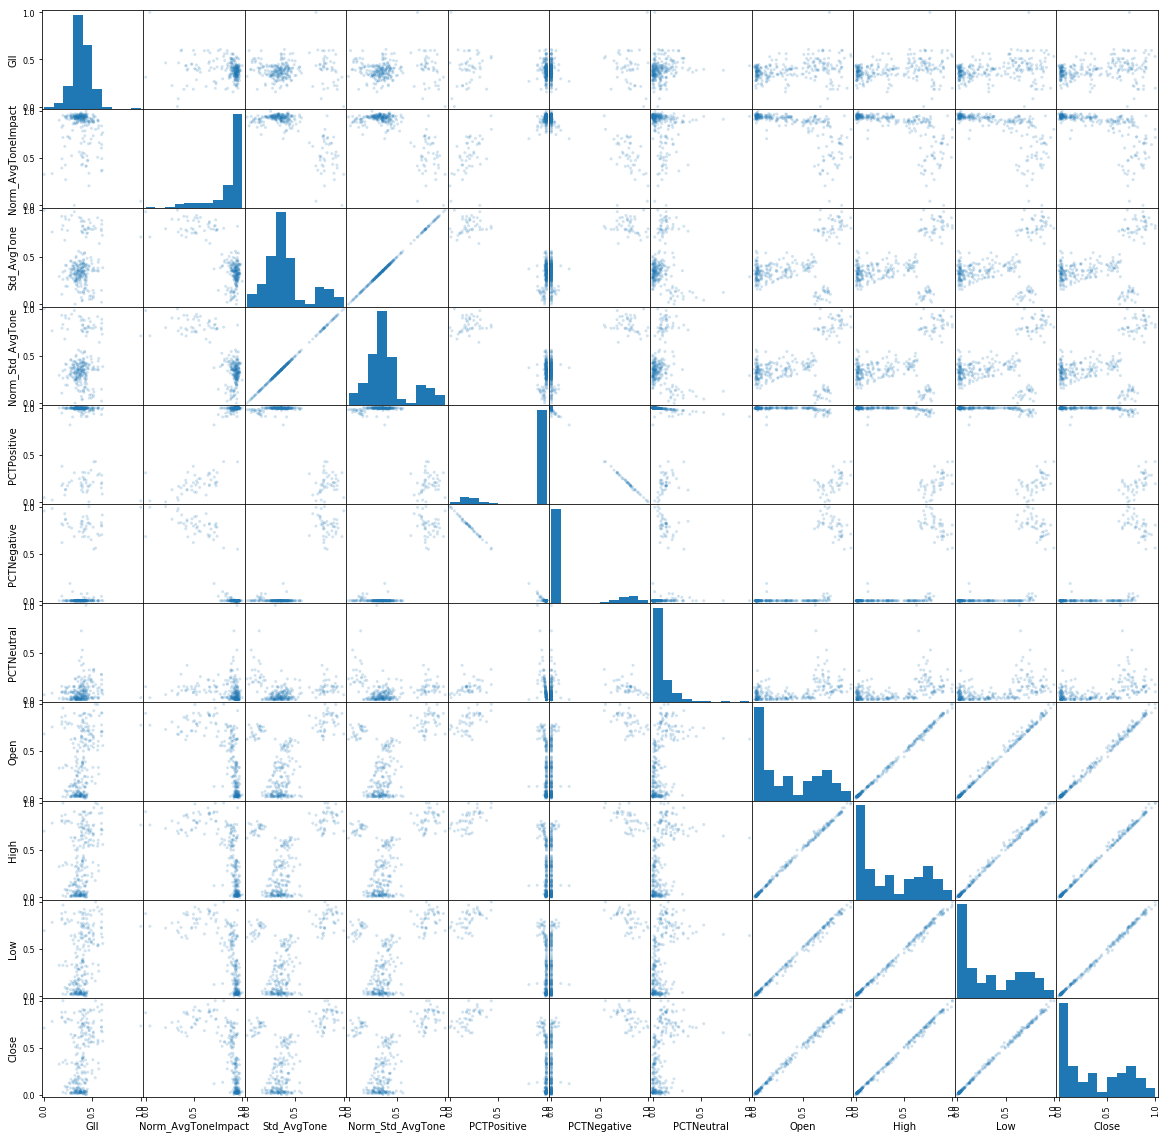

In [13]:
pd.plotting.scatter_matrix(scaled_data.drop(columns = ['AvgGI', 'StdGI', 'Norm_AvgTone', 'Volume'], axis = 1), alpha=0.2, figsize=(20,20))

In [14]:
scaled_data.drop(columns = ['AvgGI', 'StdGI', 'Norm_AvgTone', 'Volume'], axis = 1).corr()

,GII,Norm_AvgToneImpact,Std_AvgTone,Norm_Std_AvgTone,PCTPositive,PCTNegative,PCTNeutral,Open,High,Low,Close
GII,1.000000,-0.140810,0.035717,0.035717,-0.102993,0.097480,0.175175,0.270833,0.270223,0.258408,0.262489
Norm_AvgToneImpact,-0.140810,1.000000,-0.768971,-0.768971,0.897229,-0.897899,-0.146127,-0.657750,-0.650979,-0.654241,-0.648157
Std_AvgTone,0.035717,-0.768971,1.000000,1.000000,-0.854711,0.860887,-0.017718,0.497815,0.491015,0.497267,0.491716
Norm_Std_AvgTone,0.035717,-0.768971,1.000000,1.000000,-0.854711,0.860887,-0.017718,0.497815,0.491015,0.497267,0.491716
PCTPositive,-0.102993,0.897229,-0.854711,-0.854711,1.000000,-0.999402,-0.200947,-0.678494,-0.671952,-0.678665,-0.671972
PCTNegative,0.097480,-0.897899,0.860887,0.860887,-0.999402,1.000000,0.166962,0.667480,0.660942,0.667626,0.660943
PCTNeutral,0.175175,-0.146127,-0.017718,-0.017718,-0.200947,0.166962,1.000000,0.436938,0.435607,0.437683,0.436167
Open,0.270833,-0.657750,0.497815,0.497815,-0.678494,0.667480,0.436938,1.000000,0.999125,0.997676,0.997818
High,0.270223,-0.650979,0.491015,0.491015,-0.671952,0.660942,0.435607,0.999125,1.000000,0.997898,0.998895
Low,0.258408,-0.654241,0.497267,0.497267,-0.678665,0.667626,0.437683,0.997676,0.997898,1.000000,0.999097


([<matplotlib.axis.XTick at 0x25914f43b38>,
 <a list of 8 Text xticklabel objects>)

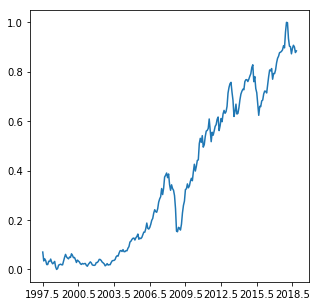

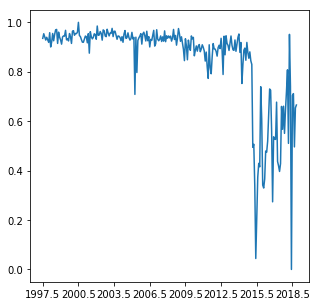

In [15]:
FractionMonth = scaled_data.MonthYear.str[0:4].astype('int64') + scaled_data.MonthYear.str[4:6].astype('int64') / 12

# Plot Month vs Closing Harga Saham
plt.figure(figsize = (5,5))
plt.plot(FractionMonth, scaled_data.Close)
plt.xticks(np.arange(min(FractionMonth), max(FractionMonth), 3 ))

# Plot Month vs Normalized AvgTone Impact Index
plt.figure(figsize = (5,5))
plt.plot(FractionMonth, scaled_data.Norm_AvgToneImpact)
plt.xticks(np.arange(min(FractionMonth), max(FractionMonth), 3 ))